In [1]:
import keras,os
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
import warnings 
from imblearn.over_sampling import SMOTE
warnings.filterwarnings("ignore")

In [3]:
import os
from distutils.dir_util import copy_tree, remove_tree

base_dir = r"C:\Users\Sreek\Dropbox\PC\Downloads\archive(12)\Alzheimer_s Dataset"
root_dir = "./"
test_dir = os.path.join(base_dir, "test/")
train_dir = os.path.join(base_dir, "train/")
work_dir = os.path.join(root_dir, "dataset/")

if os.path.exists(work_dir):
    remove_tree(work_dir)

os.mkdir(work_dir)

copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)

print("Working Directory Contents:", os.listdir(work_dir))


Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [4]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 128
IMAGE_SIZE = [128,128]
DIM = (IMG_SIZE, IMG_SIZE)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = ImageDataGenerator(rescale=1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=work_dir, target_size=DIM, batch_size=6500, shuffle=False)


Found 6400 images belonging to 4 classes.


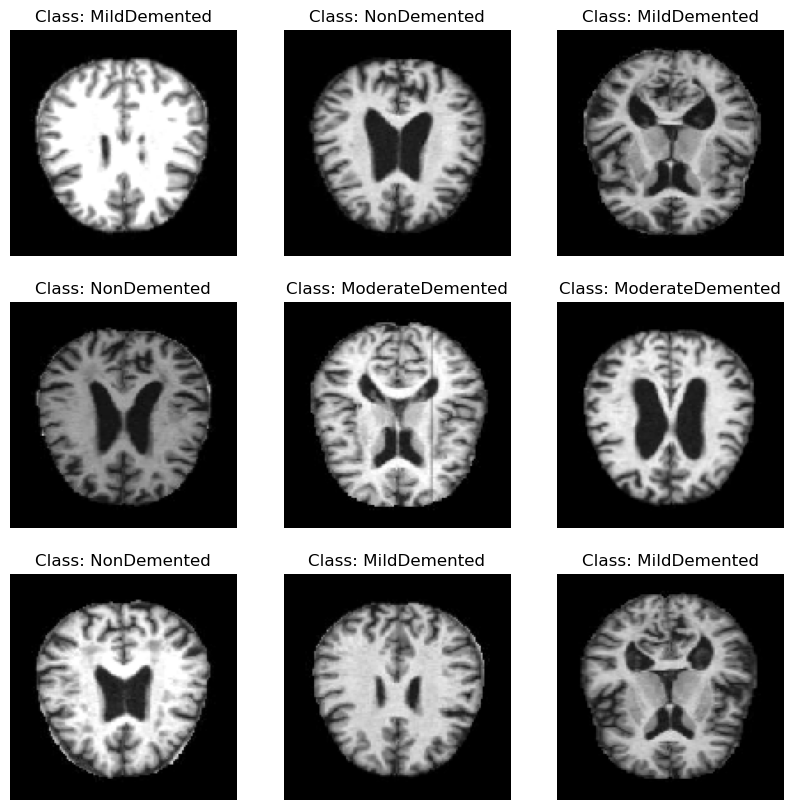

In [8]:
import numpy as np  

def show_images(generator, y_pred=None):
    """
    Input: An image generator, predicted labels (optional)
    Output: Displays a grid of 9 images with labels
    """
    labels = dict(zip([0, 1, 2, 3], CLASSES))  

    x, y = generator.next()

    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = np.random.randint(0, x.shape[0])  
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class: {}".format(labels[np.argmax(y[idx])]))
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual: {} \nPredicted: {}".format(labels[np.argmax(y[i])], labels[y_pred[i]]))

show_images(train_data_gen)


In [9]:
train_data, train_labels = train_data_gen.next()

In [10]:
print(train_data.shape, train_labels.shape)

(6400, 128, 128, 3) (6400, 4)


In [11]:



sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)



(12800, 128, 128, 3) (12800, 4)


In [12]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [13]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense
from tensorflow.keras.models import Sequential
vgg16_model = VGG16(input_shape=(176, 176, 3), include_top=False, weights='imagenet')

In [14]:


for layer in vgg16_model.layers:
    layer.trainable = False



In [15]:
custom_vgg16_model = Sequential([
    vgg16_model,
    Dropout(0.5),
    GlobalAveragePooling2D(),
    Flatten(),
    BatchNormalization(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(4, activation='softmax')        
], name="vgg16_cnn_model")

custom_vgg16_model.summary()

Model: "vgg16_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 5, 5, 512)         0         
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)           

In [17]:
import tensorflow.keras.callbacks

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True

my_callback = MyCallback()

rop_callback = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3)


In [18]:
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.metrics import CategoricalAccuracy, AUC
import tensorflow_addons as tfa

rmsprop_optimizer = RMSprop(learning_rate=0.001)
adam_optimizer = Adam(learning_rate=0.001)
sgd_optimizer = SGD(learning_rate=0.01, momentum=0.9)

rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

METRICS = [CategoricalAccuracy(name='acc'),
           AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=4)]

custom_vgg16_model.compile(optimizer=rmsprop_optimizer,
                                   loss=tf.losses.CategoricalCrossentropy(),
                                   metrics=METRICS)

custom_vgg16_model.summary()

Model: "vgg16_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 5, 5, 512)         0         
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)           

In [26]:
input_shape = (128, 128, 3)

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True

rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

callbacks = [MyCallback(), rop_callback]

EPOCHS = 100

custom_vgg16_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

custom_vgg16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = custom_vgg16_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=callbacks, epochs=EPOCHS)

Epoch 1/100
256/256 [==============================] - 44s 169ms/step - loss: 1.1790 - accuracy: 0.4175 - val_loss: 0.7122 - val_accuracy: 0.6699 - lr: 0.0010
Epoch 2/100
256/256 [==============================] - 44s 170ms/step - loss: 0.8118 - accuracy: 0.5829 - val_loss: 0.6592 - val_accuracy: 0.6680 - lr: 0.0010
Epoch 3/100
256/256 [==============================] - 44s 173ms/step - loss: 0.7573 - accuracy: 0.6050 - val_loss: 0.6377 - val_accuracy: 0.7158 - lr: 0.0010
Epoch 4/100
256/256 [==============================] - 44s 171ms/step - loss: 0.7254 - accuracy: 0.6289 - val_loss: 0.5952 - val_accuracy: 0.7324 - lr: 0.0010
Epoch 5/100
256/256 [==============================] - 44s 171ms/step - loss: 0.6871 - accuracy: 0.6490 - val_loss: 0.5230 - val_accuracy: 0.7515 - lr: 0.0010
Epoch 6/100
256/256 [==============================] - 42s 165ms/step - loss: 0.6495 - accuracy: 0.6721 - val_loss: 0.5077 - val_accuracy: 0.7729 - lr: 0.0010
Epoch 7/100
256/256 [=========================

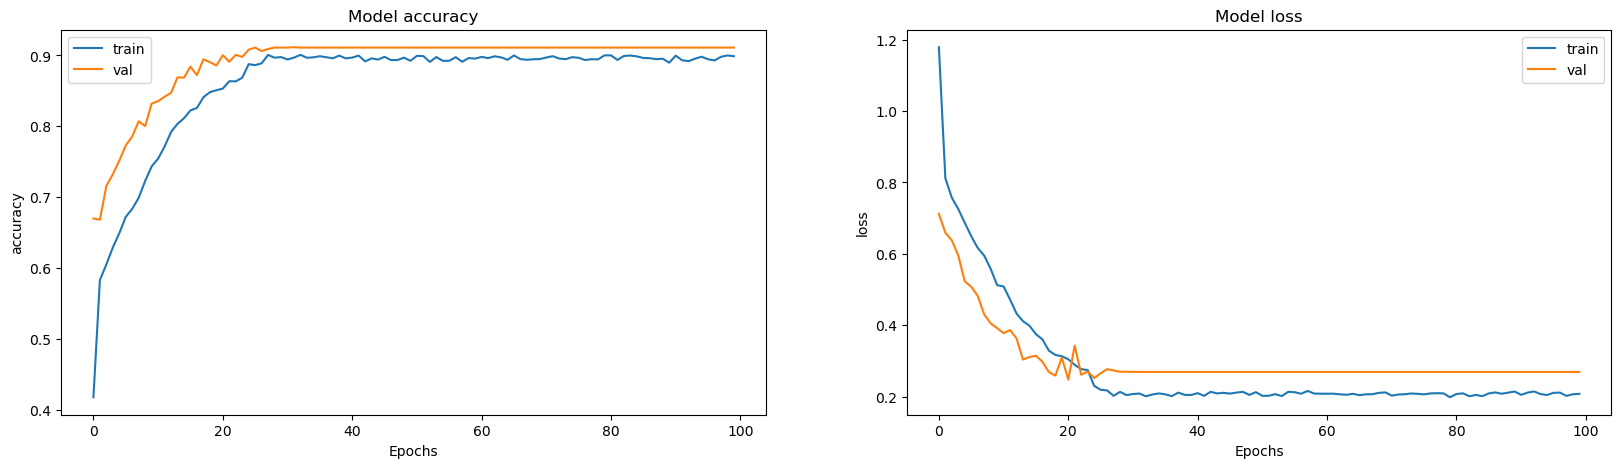

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))  
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]):  
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])


In [32]:
y_prob = custom_vgg16_model.predict(test_data)

y_true = np.argmax(test_labels, axis=1)

print(classification_report(y_true, y_pred))

print(classification_report(y_true, y_pred))



80/80 [==============================] - 3s 38ms/step
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       639
           1       1.00      1.00      1.00       635
           2       0.91      0.80      0.85       662
           3       0.81      0.89      0.84       624

    accuracy                           0.92      2560
   macro avg       0.92      0.92      0.92      2560
weighted avg       0.92      0.92      0.92      2560

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       639
           1       1.00      1.00      1.00       635
           2       0.91      0.80      0.85       662
           3       0.81      0.89      0.84       624

    accuracy                           0.92      2560
   macro avg       0.92      0.92      0.92      2560
weighted avg       0.92      0.92      0.92      2560



In [33]:
custom_vgg16_model.save("custom_vgg16_model.h5")


In [14]:
from tensorflow.keras.models import load_model

custom_vgg16_model = load_model("custom_vgg16_model.h5")



C:\Users\Sreek\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

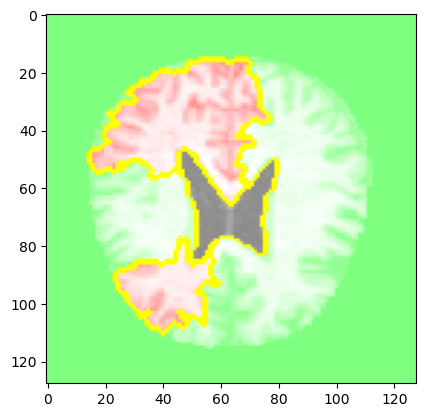

Predicted class number: 3


In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Now you can use plt to plot graphs, images, etc.

import lime
from lime import lime_image
from tensorflow.keras.preprocessing import image

explainer = lime_image.LimeImageExplainer()

def preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return img_array_expanded_dims / 255.

img_path = r"C:\Users\Sreek\Dropbox\PC\Downloads\archive(12)\Alzheimer_s Dataset\test\VeryMildDemented\27 (11).jpg"
processed_image = preprocess_image(img_path, target_size=(128, 128))

preds = custom_vgg16_model.predict(processed_image)

explanation = explainer.explain_instance(processed_image[0].astype('double'), 
                                         custom_vgg16_model.predict, 
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000)

from skimage.segmentation import mark_boundaries

temp, mask = explanation.get_image_and_mask(preds[0].argmax(), positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()
predicted_class = preds.argmax()
print(f"Predicted class number: {predicted_class}")